# Motivation 

For the network science part of the assignment we have chosen to  create a social socialnetwork of the game of thrones characters. This can be done in multiple ways e.g. by considering family ties or using information from the books (A song of ice and fire).  We, however, have chosen to substract the information nessesary to create a social network by accesing text data from https://gameofthrones.fandom.com. The fandom page comprise information of  the characters,  houses, episode etc. Regarding the later, the website has one page for each episode which consists of summaries of the episode of question. All summeries are partitioned into geographical location that is there is, for each episode page there is a short section with a summary for each geographical location where the act of that season takes place. 

Since we are interested in creating a social network that holds information of connections between characters in Game of Thrones not A song of ice and fire, we have chosen to create a social network based on the summaries of each episode. The general thought is that if two characters are mentioned in same summary they are placed in the same geographical location in an episode. In Game of Thrones the known worls consists of the three continents Essos, Westeros and Sothoryos as well as a range of smaller icelands. Most of the series takes place at Whesteros where the seven kingdomsas well as "the wall" and "beyind the wall"  are located. Essos plays a large role as well as it is home to the 9 free cities and the dothraki tribes. 

Most characters has a strong connections to a house of Westeros or a tribe/locations in Essos. Change of loyality happens and the main characters travels often, however no one travels fast and change of loyality often means change of geographical locations. Thus we find that it is interesting to build a social network of based on the geographical location of the characters.

The data used for the network science part of the assignemnt is accessed with webscrabing.

The goal for the network science park of the assignemt is to visualise connections among the characters with a graph. To introduce a nice overview, it shall be clear who the main characters are and which characters has the strongest connections. Moreover, to analyse how well the geographical locations defindes the connections among characters we will look at communities of the network. The communities together with prior knowledge of Game of Thrones will be used to From this, the goal is to show  

and show communities of the network.

In [1]:
#john snow, tyrion, cercei, arya, denaries, jamie lannister, 



In [19]:
import pandas as pd
import json
from ast import literal_eval
import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
import community as community_louvain
from itertools import combinations
import re
from nltk import word_tokenize
import seaborn as sns
import pickle
from copy import deepcopy

In [3]:
def Plot(Samples, Names, color,numbins, name,xlab, ylab, save = False):
    fig, ax = plt.subplots(1,1)
    sns.set_style("darkgrid")
     
    MAX = np.max(Samples)
    MIN = np.min(Samples)
    bins = np.linspace(MIN,MAX,numbins)
    hist, edges = np.histogram (Samples, bins = bins, density = False)
    x = (edges[1:]+edges[:-1])/2
    width = bins[1]-bins[0]


    ax.bar(x, hist, width = width*0.9, color =  color)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(Names)
    
    if save:
    
        plt.savefig(name)
    
    plt.show()
    
    return

### Function for data cleaning

In [4]:
def CleanData(data): 
    
    """
    input: dataframe with columns: season, episode, geographical location, text
    
    returns: cleaned dataframe with same columns
    """
    # remove "recap" secitons
    IndicesToBeRemoved = data.index[data['geo'] == 'Recap'].tolist()
    data = data.drop(IndicesToBeRemoved, axis=0)   

    # Get on list form 
    data['text']  = [literal_eval(l) for l in data.text]

    # remove newline
    for i in range(len(data)):
        text = data['text'].iloc[i]

        # remove newline
        text = [t.strip() for t in text]

        # split in non-sign tokens
        tokens = []
        for t in text: 
            tokens = tokens + re.split(r'\W', t)

        # join tokens 
        text = ' '.join(tokens)
        text = text.replace(' s ', ' ')
        text = text.replace('  ', ' ')

        data['text'].iloc[i] = text
    
    return data

### Function for characternames loading

In [5]:
def CharacterNames(path):
    """
    input: path to json
    returns: list of character names 
    """
    
    CN = []
    with open(path) as json_file:
        data = json.load(json_file)
        for p in data['characters']:
            CN.append(p['characterName'])

    removes = []
    for name in CN: 
        if "Little Bird" in name or 'Great Master' in name or "Night's" in name or "White Walker" in name or 'Musician' in name or "Winterfell" in name:
            removes.append(name)
        if "Guard" in name or "Bloodrider" in name or "Goldcloak" in name or "King's Landing Rioter" in name or "Dwarf" in name or "Old Man" in name:
            removes.append(name)
            
        if "Bannerman" in name or "Young" in name or "Lannister Captain" in name or "Lannister Captain" in name or "Wedding" in name or 'Ghost' in name:
            removes.append(name)
        
        if "Lannister Messenger" in name or "Lannister Scout" in name or "Nymeria Sand" in name: 
            removes.append(name)
            

    removes.append("Lady")

    CN = [name for name in CN if name not in removes] 

    CN = CN + ['Varys', "The Mountain", "Selyse Florent" , "Littlefinger",
                                     "Wun Weg Wun Dar Wun", "Harrag", "Archmaester Ebrose", "The High Sparrow", 'Dany']
    
    CN = np.array(CN)
    CN[CN == 'Ramsay Snow'] = 'Ramsay Snow/Bolton'
    
    return CN


# Method for finding connected characters
#### Characters who appears in same geographical location in same episode.

In [34]:
def GetFullyConnectedSubgraps(data, CN): 
    
    """
    input: data: data with season, episode, geo and text. 
           CN: list of characternames
           n1, nh: character specific information (n1: keep 2. name, nh: keep full name)
           
    returns: dict with (season, episode, geo) as key and names of characters connected via info from key
             and list of name triplets (name to search for, name to search for minus space, full name)
    """
    
    # Names for special   treatment 
    n1 = ["Archmaester", "Baby", "Barristan", "Captain", "Khal"]
    nh = ["Black", "Brother", "Child", "Grey", "High", "Knight" , "Robert", "Rickard", "Three-eyed", "The", "Wun", "Will", "Lord", "Jon", "Red", "Maester", "Ser", "Lyanna", "Lady", 
     "Grand", "Old", "Septa", "Hot", "Thin", "Lem", "Selyse", "Nymeria", "Arthur", "Jaqen", "Margaery"]
    
    # Get connections
    Connections = {}
    CleanCN = []
    for _,row in data.iterrows(): #all texts 
        TextEdges = []

        for name in CN: #all names 
            n = name

            # first name 
            if ' ' in name:
                fn = re.split(r'\W', name)[0] #first name 
                ln = re.split(r'\W', name)[1] #last name

                if fn in nh or ln == 'of': 
                    n = name

                elif fn in n1: 
                    n = ln          
                else:
                    n = fn

            else: 
                pass

            if n in row['text']:  #check if name in text 
                TextEdges.append(name)
                if (n, n.replace(" ", ""), name) not in CleanCN: 
                    CleanCN.append((n, n.replace(" ", ""), name))

        # Store connection 
        Connections[(row['season'],row['episode'], row['geo'])] = set(TextEdges)
        
    # Replace "Dany" with 'Daenerys Targaryen'
    Connections_copy = deepcopy(Connections)
        
    for key, val in Connections.items():
        if "Dany" in val:
            Connections_copy[key].remove("Dany")
            Connections_copy[key].add('Daenerys Targaryen')
    
    Connections = Connections_copy
    if ('Dany', 'Dany', 'Dany') in CleanCN: 
        CleanCN.remove(('Dany', 'Dany', 'Dany'))
            
    
    return Connections, CleanCN



# Methods for finding weights and links

In [7]:
def NodeWeight(text, CN):
    """
    input: text: String 
    input: CN: List of tripplets with names (name to search for, name to search for minus space, full name)
    returns: count_dict: frequency of names in text
    """
    
    CN0 = [i for i,_,_ in CN]
    CN1 = [i for _,i,_ in CN]
    CN2 = [i for _,_,i in CN]

    #remove space in names of interest 
    for cn0, cn1 in zip(CN0, CN1):
        text = text.replace(cn0, cn1)
        
    # Tokenize
    tokens = word_tokenize(text)
        
    count_dict = {name: 0 for name in CN2}
    
    for word in tokens:
        if word in CN1:
            
            idx = CN1.index(word)
            count_dict[CN2[idx]] = count_dict[CN2[idx]] + 1
            
    return count_dict

In [8]:
def GetEdges(Connections): 
    
    """
    input: Connections: dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text
    
    returns: set of edges
    """
    
    # Get all edges
    Edges = []
    for g in Connections.values(): 
        Edges += [i for i in combinations(g, 2)] #for each fully connected subgraph, add all links in that graph 

    # Remove double. tripple etc. edges 
    Edges = [tuple(sorted(edge)) for edge in Edges]
    Edges = set(Edges)
    
    return Edges

In [9]:
def GetLinkWeights(Edges, Connections):
    
    """
    input: Edges: Set of Edges
           Connections: dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text
           
    returns: WeightsInput: list of triplets each with a pair of connected nodes as well as the link weight. 
    """
    
    Weights = {edge: 0 for edge in Edges}
    for edge in Weights.keys(): 
        w = 0
        for s in Connections.values(): 
            if (edge[0] in s) and (edge[1] in s): 
                w +=1
        Weights[edge] = w

    WeightsInput = [(key[0],key[1], {'weight': val}) for key, val in Weights.items()] 
    
    return WeightsInput

# Weighted graph method

In [10]:
# Join all text

def WeightedGraph(data, Connections, CleanCN, directed = False): 
    
    """
    input: Connections:  dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text            
           data: dataframe with text etc
           CleanCN: characterNames 
           directed: True if returned network is directed else false. 
           
    returns: Weighted graph or weighted directed graph.
             link_weight: weight of links. Used for cutof outside function
             
    """
    
    #Join text 
    alltext = ' '.join(data.text.values)
    
    # Compute node weights
    node_weight = NodeWeight(alltext, CleanCN)
    
    # Find links: 
    Edges = GetEdges(Connections)
    
    # Compute link weight
    link_weight = GetLinkWeights(Edges, Connections)
    
    # Initialise weighted graph: 
    if directed: 
        G_W = nx.MultiDiGraph()
    else: 
        G_W = nx.Graph()

    # Add nodes
    G_W.add_nodes_from(set().union(*Connections.values()), LouvainPartition = None, group = None, size = None)

    # Add node size (weight)
    for key, val in node_weight.items(): 
        G_W.nodes[key]['size'] = val

    
    if directed:
        edge1 = [(i,j,w['weight']) for i,j,w in link_weight]
        edge2 = [(j,i,w['weight']) for i,j,w in link_weight]
        G_W.add_weighted_edges_from(edge1 + edge2)
        
        
        
    else: 
        # Add links and weights
        G_W.add_edges_from(link_weight)
    
        
        # Remove nodes with zero degree
        #G_W = ZeroDegCutOff(G_W)
    
    return G_W
    

# Unweighted graph method

In [11]:
def UnweightedGraph(Connections):
    
    # Compute links: 
    Edges = GetEdges(Connections)

    #Initialise
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(set().union(*Connections.values()), LouvainPartition = None, group = None)

    # Add edges to graph 
    G.add_edges_from(Edges)  
    
    # Remove nodes with zero degee
    #G = ZeroDegCutOff(G)
    
    return G

# Modularity

In [12]:
def GraphModularity(graph, p):
    """
    input: graph: networkX graph or list of nodes and attributes
           p: Partition definer: list containing attribute dict key and tuple with attribute dict values
           
    return: Modularity of graph
    """
    #Number of links in graph: 
    L = len(graph.edges())

    M = 0
    key = p[0] #
    p = p[1]
    deg = {i:0 for i in p}
    links = {i:0 for i in p}

    # loop through graph nodes: 
    for node in graph: 
        par = graph.nodes[node][key] # node partition 
        deg[par] += graph.degree[node] # node degree

        l = sum([w.get('weight', 1)/2 for n,w in graph[node].items() if graph.nodes[node][key] == graph.nodes[n][key]])

        links[par] += l


    for par in p: 
        M += links[par]/L - (deg[par]/(2*L))**2

    return M

# Prepare data

In [13]:
def GetSeasonData(season):

    # Load data
    if season == 'all': 
        data = pd.read_csv('GOT.csv')
        s = "all seasons: "
    else: 
        data = pd.read_csv('GOT.csv')
        data = data[data["season"] == season]
        s = season +  ": "

    # Clean data 
    data = CleanData(data)  
    
    return data

# Create graphs and plot for each seasons

In [20]:
CN = CharacterNames('characters.json')

## Season 1

In [21]:
# Get data: 
season = 'season1'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)
#data


### Weighted graph

Number of nodes in weigthed graph of season 1: 108
Number of links in weighted graph of season 1: 1796


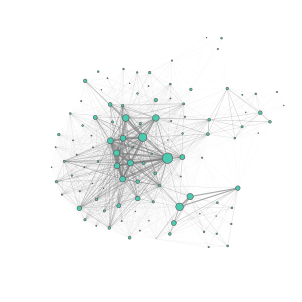

In [22]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/Gseason1.gpickle")

# Plot graph
WGraphVisu1, _ = nw.visualize(G_W)
# store graph visualisations in pickle
with open('GraphPlots/Season1W.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu1, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 1: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 1: " + str(len(G_W.edges())))

### Plot degree, edge weight and node size distribution

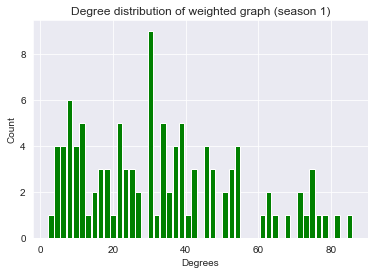

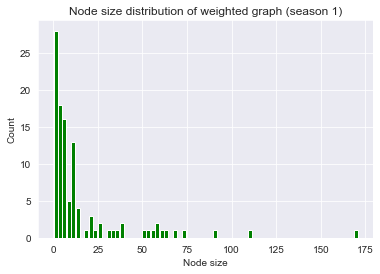

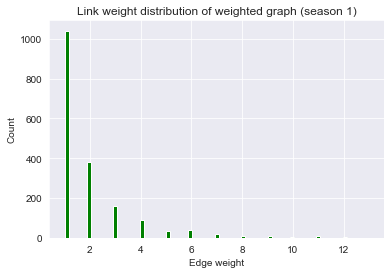

In [27]:
# Out degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 1)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 1)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 1)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")

# Unweighted graph

In [28]:
# Define graph
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 1: " + str(len(G.nodes())))
print("Number of links in unweighted graph of season 1: " + str(len(G.edges())))

Number of nodes in unweigthed graph of season 1: 108
Number of links in unweighted graph of season 1: 1796


### Degree distributions

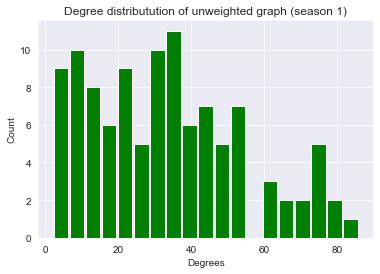

In [29]:
# Plot degree distribution of graph before cutoff
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 1)", "green", 20, "GraphPlots/" + "season1" + "degreedit.png", "Degrees", "Count", save = True)

### Partitioning unweighted graph with louvain

In [32]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason1unweight.gpickle")

# Visualise graph
#GraphVisu1, _ = nw.visualize(G)

# store graph visualisations in pickle
with open('GraphPlots/Season1.pickle', 'wb') as handle:
    pickle.dump(GraphVisu1, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 1: " +  str(GraphModularity(G,partitioning)))

Modularity of unweighted of season 1: 0.20009185842332133


# Season 2

In [35]:
# Get data: 
season = 'season2'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

Number of nodes in weigthed graph of season 2: 109
Number of links in weighted graph of season 2: 1007


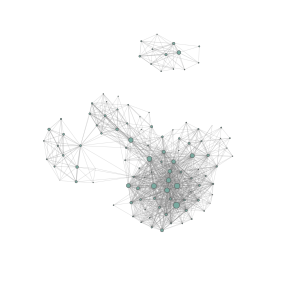

In [36]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/Gseason2.gpickle")

# Plot graph
WGraphVisu2, _ = nw.visualize(G_W)

# store graph visualisations in pickle
with open('GraphPlots/Season2W.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 2: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 2: " + str(len(G_W.edges())))

#### Plot distributions

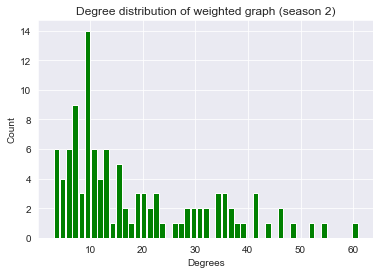

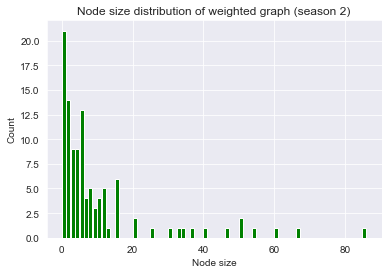

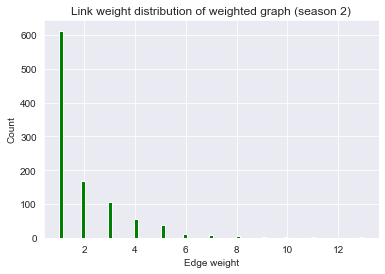

In [37]:
# Out degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 2)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 2)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 2)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")

### Unweighted graph

### 

Number of nodes in unweigthed graph of season 2109
Number of links in unweighted graph of season 21007


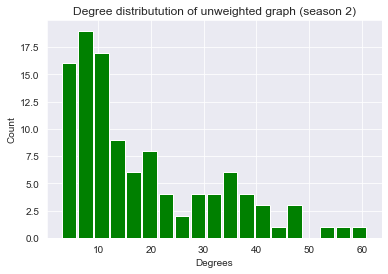

In [38]:
# Define graph
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 2" + str(len(G.nodes())))
print("Number of links in unweighted graph of season 2" + str(len(G.edges())))

# Plot degree distribution of graph before cutoff
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 2)", "green", 20, "GraphPlots/" + "season2" + "degreedit.png", "Degrees", "Count", save = True)

#### Louvain

Modularity of unweighted of season 2: 0.38219454878413167


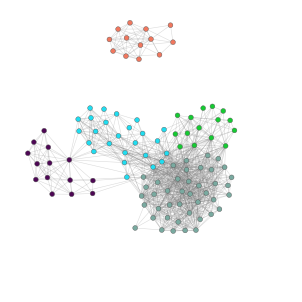

In [39]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason2unweight.gpickle")

#Visualise graph
GraphVisu2, _ = nw.visualize(G)

# store graph visualisations in pickle
with open('GraphPlots/Season2.pickle', 'wb') as handle:
    pickle.dump(GraphVisu2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 2: " +  str(GraphModularity(G,partitioning)))

## Season 3

In [40]:
# Get data: 
season = 'season3'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

Number of nodes in weigthed graph of season 3: 128
Number of links in weighted graph of season 3: 1911


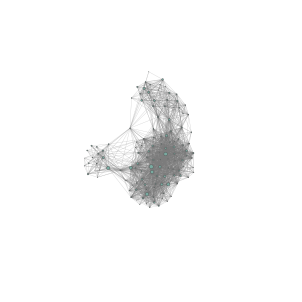

In [41]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/Gseason3.gpickle")

# Plot graph
WGraphVisu3, _ = nw.visualize(G_W)
# store graph visualisations in pickle
with open('GraphPlots/Season3W.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu3, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 3: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 3: " + str(len(G_W.edges())))

#### Plot distributions

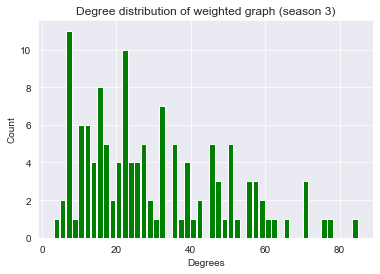

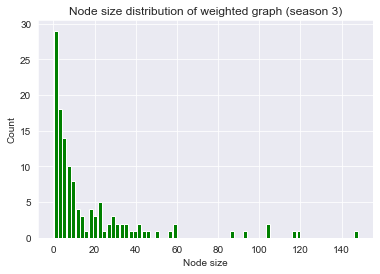

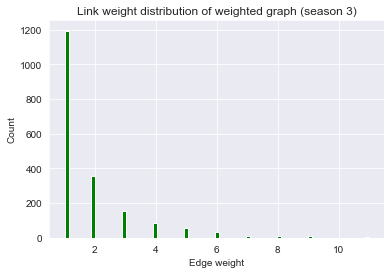

In [42]:
# Degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 3)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 3)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 3)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")



### Unweighted graph

Number of nodes in unweigthed graph of season 3: 128
Number of links in unweighted graph of season 3: 1911


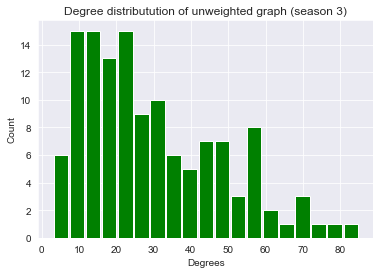

In [43]:
# Define graph
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 3: " + str(len(G.nodes())))
print("Number of links in unweighted graph of season 3: " + str(len(G.edges())))


# Plot degree distribution of graph before cutoff
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 3)", "green", 20, "GraphPlots/" + "season3" + "degreedit.png", "Degrees", "Count", save = True)

#### Louvain

Modularity of unweighted of season 3: 0.3551959366043242


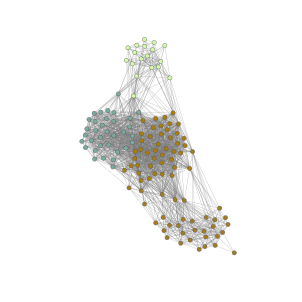

In [44]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason3unweight.gpickle")

# Visualise graph
GraphVisu3, _ = nw.visualize(G)
# store graph visualisations in pickle
with open('GraphPlots/Season3.pickle', 'wb') as handle:
    pickle.dump(GraphVisu3, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 3: " +  str(GraphModularity(G,partitioning)))

## Season 4

In [45]:
# Get data: 
season = 'season4'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

Number of nodes in weigthed graph of season 4: 120
Number of links in weighted graph of season 4: 1556


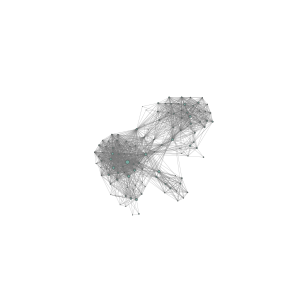

In [46]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/Gseason4.gpickle")

# Plot graph
WGraphVisu4, _ = nw.visualize(G_W)
# store graph visualisations in pickle
with open('GraphPlots/Season4W.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu4, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 4: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 4: " + str(len(G_W.edges())))

#### Plot distributions

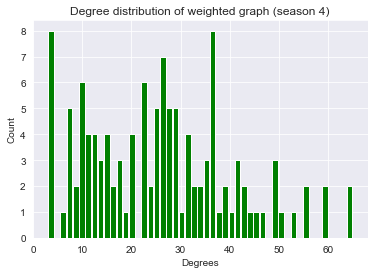

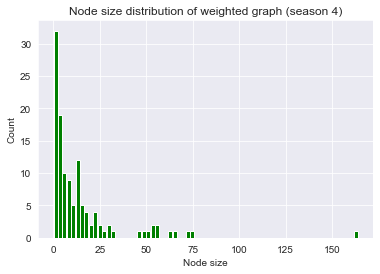

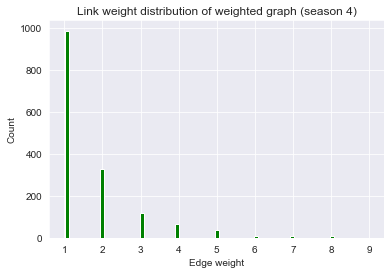

In [47]:
# Degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 4)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 4)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 4)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")



### Unweighted graph

Number of nodes in unweigthed graph of season 4: 120
Number of links in unweighted graph of season 4: 1556


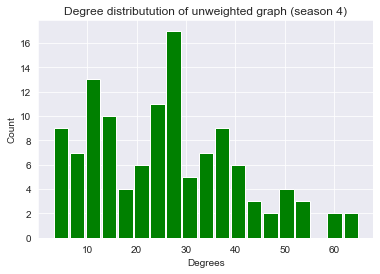

In [48]:
# Define graph
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 4: " + str(len(G.nodes())))
print("Number of links in unweighted graph of season 4: " + str(len(G.edges())))

# Plot degree distribution of graph before cutoff
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 4)", "green", 20, "GraphPlots/" + "season4" + "degreedit.png", "Degrees", "Count", save =  True)



#### Louvain

Modularity of unweighted of season 4: 0.42875121430601176


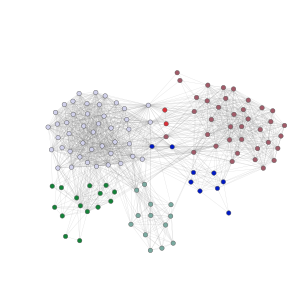

In [49]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason4unweight.gpickle")

# Visualise graph
GraphVisu4, _ = nw.visualize(G)

# store graph visualisations in pickle
with open('GraphPlots/Season4.pickle', 'wb') as handle:
    pickle.dump(GraphVisu4, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 4: " +  str(GraphModularity(G,partitioning)))

## Season 5

In [50]:
season = 'season5'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

Number of nodes in weigthed graph of season 5: 123
Number of links in weighted graph of season 5: 1137


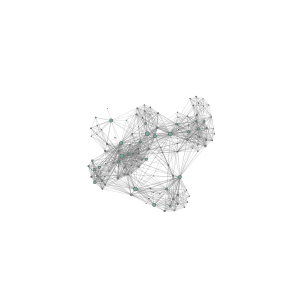

In [51]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/Gseason5.gpickle")

# Plot graph
WGraphVisu5, _ = nw.visualize(G_W)

# store graph visualisations in pickle
with open('GraphPlots/Season5W.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu5, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 5: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 5: " + str(len(G_W.edges())))

#### Plot distributions

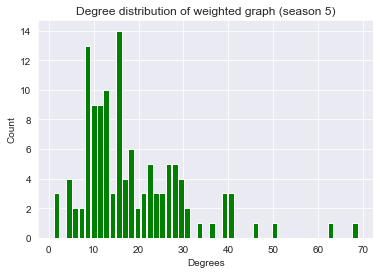

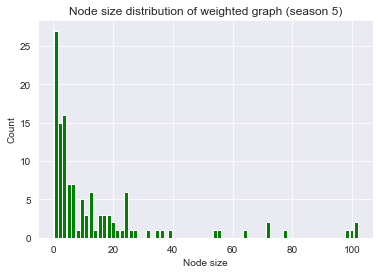

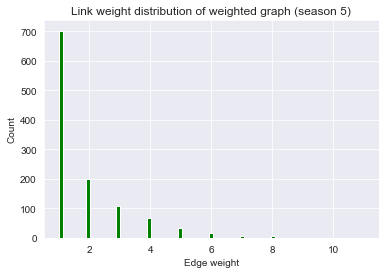

In [52]:
# Out degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 5)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 5)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 5)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")


### Unweighted graph

Number of nodes in unweigthed graph of season 5123
Number of links in unweighted graph of season 51137


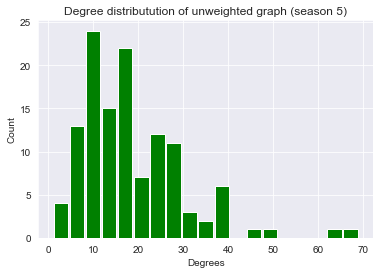

In [53]:
# Define graph
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 5" + str(len(G.nodes())))
print("Number of links in unweighted graph of season 5" + str(len(G.edges())))


# Plot degree distribution of graph before cutoff
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 5)", "green", 20, "GraphPlots/" + "season5" + "degreedit.png", "Degrees", "Count", save = True)



#### Louvain

Modularity of unweighted of season 5: 0.5011169822296172


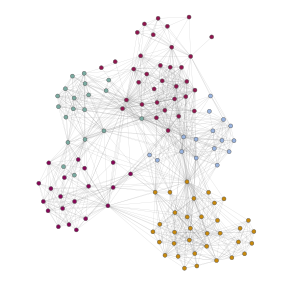

In [54]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason5unweight.gpickle")

# Visualise graph
GraphVisu5, config = nw.visualize(G)

# store graph visualisations in pickle
with open('GraphPlots/Season5.pickle', 'wb') as handle:
    pickle.dump(GraphVisu5, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 5: " +  str(GraphModularity(G,partitioning)))

## Season 6

In [55]:
# Get data: 
season = 'Season_6'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)


### Weighted graph

Number of nodes in weigthed graph of season 6: 143
Number of links in weighted graph of season 6: 1250


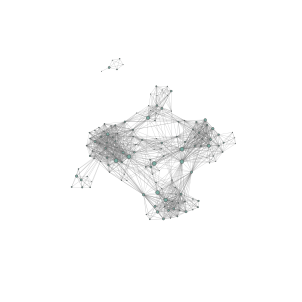

In [56]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/season6.gpickle")

# Plot graph
WGraphVisu6, _ = nw.visualize(G_W)

# Store visualisations in pickle
with open('GraphPlots/Season6W.pickle.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu6, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 6: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 6: " + str(len(G_W.edges())))

#### Plot distributions

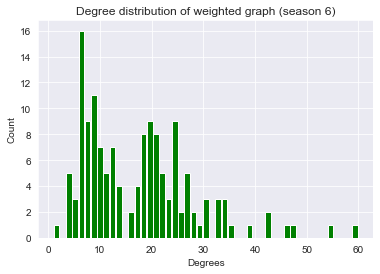

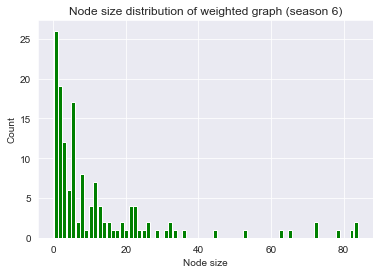

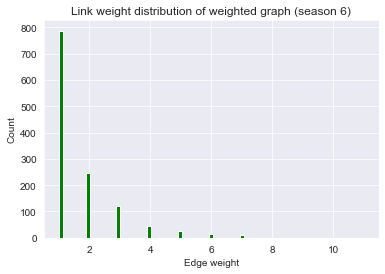

In [57]:
# Degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 6)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 6)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 6)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")

### Unweighted graph

Number of nodes in unweigthed graph of season 6: 143
Number of links in unweighted graph of season 6: 1250


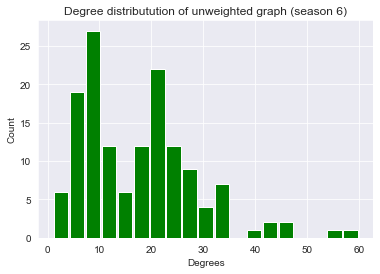

In [58]:
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 6: " + str(len(G.nodes())))
print("Number of links in unweighted graph of season 6: " + str(len(G.edges())))


# Plot degree distribution of graph before cutoff
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 6)", "green", 20, "GraphPlots/" + "season6" + "degreedit.png", "Degrees", "Count", save = True)

#### Louvain

Modularity of unweighted of season 6: 0.5428524800000001


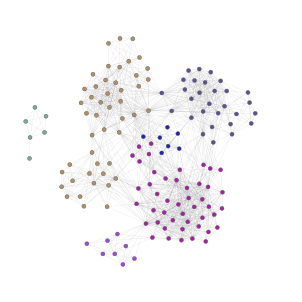

In [59]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason6unweight.gpickle")

# Visualise graph
GraphVisu6, _ = nw.visualize(G)

# Store visualisations in pickle
with open('GraphPlots/Season6.pickle.pickle', 'wb') as handle:
    pickle.dump(GraphVisu6, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 6: " +  str(GraphModularity(G,partitioning)))

## Season 7

In [60]:
# Get data: 
season = 'Season_7'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

Number of nodes in weigthed graph of season 7: 105
Number of links in weighted graph of season 7: 2016


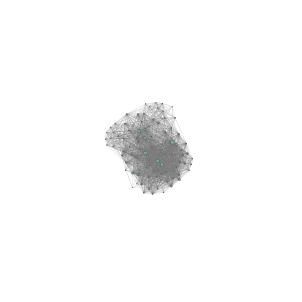

In [61]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/Gseason7.gpickle")

# Plot graph
WGraphVisu7, _ = nw.visualize(G_W)

# Store visualisations in pickle
with open('GraphPlots/Season7W.pickle.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu7, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 7: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 7: " + str(len(G_W.edges())))

#### Plot distributions

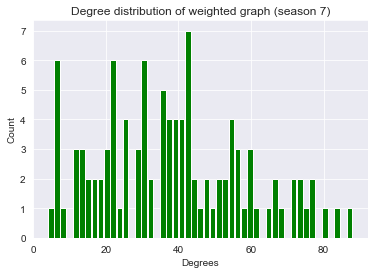

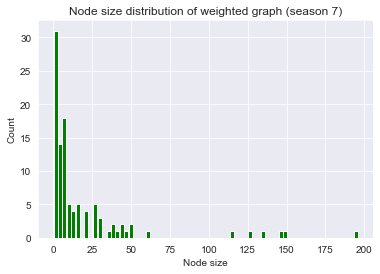

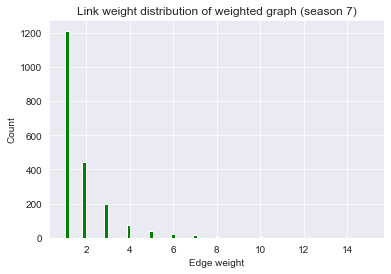

In [62]:
# Out degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 7)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 7)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 7)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")



### Unweighted graph

Number of nodes in unweigthed graph of season 7105
Number of links in unweighted graph of season 72016


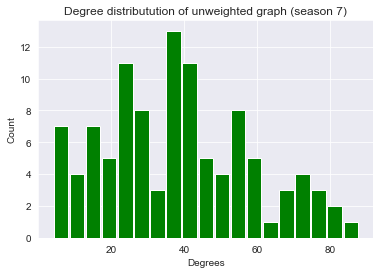

In [63]:
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 7" + str(len(G.nodes())))
print("Number of links in unweighted graph of season 7" + str(len(G.edges())))

# Plot degree distribution of graph
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 7)", "green", 20, "GraphPlots/" + "season7" + "degreedit.png", "Degrees", "Count")

#### Louvain

Modularity of unweighted of season 7: 0.21840885515085662


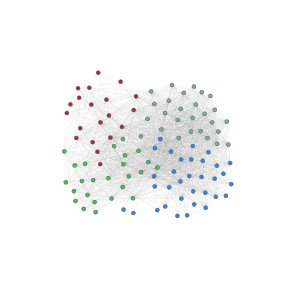

In [65]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason7unweight.gpickle")

# Visualise graph
GraphVisu7, config = nw.visualize(G)

# Store visualisations in pickle
with open('GraphPlots/Season7.pickle.pickle', 'wb') as handle:
    pickle.dump(GraphVisu7, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 7: " +  str(GraphModularity(G,partitioning)))

## Season 8

In [66]:
# Get data: 
season = 'Season_8'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

Number of nodes in weigthed graph of season 8: 73
Number of links in weighted graph of season 8: 1435


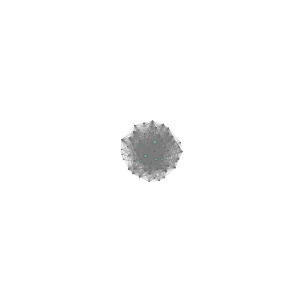

In [67]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
nx.write_gpickle(G_W, "Graphs/Gseason8.gpickle")

# Plot graph
WGraphVisu8, _ = nw.visualize(G_W)
# Store visualisations in pickle
with open('GraphPlots/Season8W.pickle.pickle', 'wb') as handle:
    pickle.dump(WGraphVisu8, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Information of graph 
print("Number of nodes in weigthed graph of season 8: " +str(len(G_W.nodes())))
print("Number of links in weighted graph of season 8: " + str(len(G_W.edges())))

#### Plot distributions

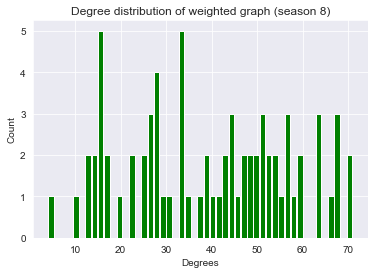

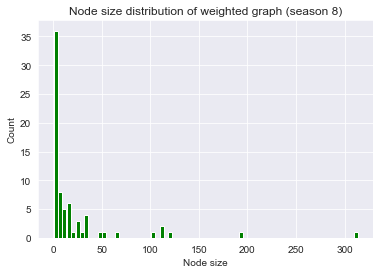

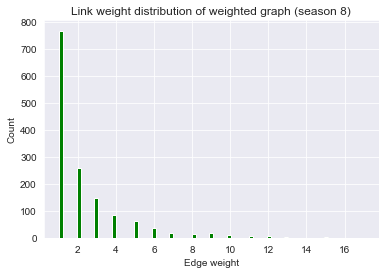

In [68]:
# Degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph (season 8)", "green", 50,name = None, xlab = "Degrees", ylab= "Count" )

# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph (season 8)", "green", 70,name = None, xlab = "Node size", ylab = "Count")

# Weight distribution
weightdist = [w['weight'] for i,j,w in G_W.edges(data=True)]
Plot(weightdist, "Link weight distribution of weighted graph (season 8)", "green", 70, name = None, xlab = "Edge weight", ylab = "Count")



### Unweighted graph

Number of nodes in unweigthed graph of season 873
Number of links in unweighted graph of season 81435


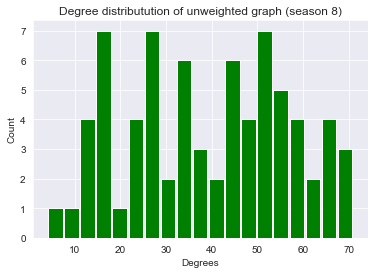

In [69]:
# Define graph
G = UnweightedGraph(Connections)

# Information of graph
print("Number of nodes in unweigthed graph of season 8" + str(len(G.nodes())))
print("Number of links in unweighted graph of season 8" + str(len(G.edges())))


# Plot degree distribution of graph before cutoff
degreedist1 = [d for _,d in G.degree()]
Plot(degreedist1, "Degree distributution of unweighted graph (season 8)", "green", 20, "GraphPlots/" + "season8" + "degreedit.png", "Degrees", "Count")

#### Louvain

Modularity of unweighted of season 8: 0.10347606502446313


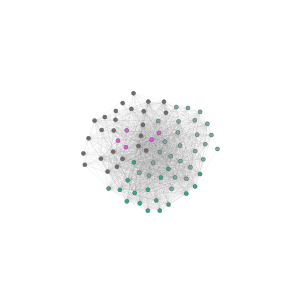

In [70]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
nx.write_gpickle(G, "Graphs/Gseason8unweight.gpickle")

# Visualise graph
GraphVisu8, _ = nw.visualize(G)
# Store visualisations in pickle
with open('GraphPlots/Season8.pickle.pickle', 'wb') as handle:
    pickle.dump(GraphVisu8, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
print("Modularity of unweighted of " +  "season 8: " +  str(GraphModularity(G,partitioning)))

# Compare seasons

## Degree distributions

## Node size distributions

## Edge weight distributions

## Number of nodes and links